# Leveraging Artificial Intelligence for Detection of Cyber Threats Based on Historical Case Perspectives

- Event profiling using TF-IDF
- Basepoint similarity calculation
- Three deep learning models: FCNN, CNN, LSTM
- Evaluation on simulated IPS security event data

In [11]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


## 1. Data Generation: Simulating IPS Security Events

We'll simulate security events similar to what an IPS would generate, with features like:
- Timestamp
- Source IP
- Destination IP
- Event type/name
- Port information
- Protocol

In [12]:
import datetime
import random
from collections import defaultdict

# Define event types (simulating IPS event names)
NORMAL_EVENTS = [
    'HTTP_TRAFFIC', 'HTTPS_TRAFFIC', 'DNS_QUERY', 'FTP_TRANSFER',
    'EMAIL_SMTP', 'SSH_LOGIN', 'DATABASE_QUERY', 'API_CALL'
]

ATTACK_EVENTS = [
    'PORT_SCAN', 'SQL_INJECTION', 'XSS_ATTACK', 'BRUTE_FORCE',
    'DDOS_SYN_FLOOD', 'MALWARE_DETECTED', 'BUFFER_OVERFLOW',
    'UNAUTHORIZED_ACCESS', 'DATA_EXFILTRATION', 'BACKDOOR_ATTEMPT'
]

def generate_ip():
    """Generate random IP address"""
    return f"{random.randint(1, 255)}.{random.randint(0, 255)}.{random.randint(0, 255)}.{random.randint(1, 255)}"

def generate_security_events(n_samples=10000, attack_ratio=0.05):
    """
    Generate simulated IPS security events
    
    Parameters:
    - n_samples: Total number of events to generate
    - attack_ratio: Proportion of attack events (default 5%)
    """
    events = []
    start_time = datetime.datetime.now() - datetime.timedelta(days=7)
    
    n_attacks = int(n_samples * attack_ratio)
    n_normal = n_samples - n_attacks
    
    # Generate normal events
    for i in range(n_normal):
        event = {
            'timestamp': start_time + datetime.timedelta(seconds=random.randint(0, 604800)),
            'source_ip': generate_ip(),
            'dest_ip': generate_ip(),
            'event_name': random.choice(NORMAL_EVENTS),
            'port': random.choice([80, 443, 22, 21, 25, 3306, 5432, 8080]),
            'protocol': random.choice(['TCP', 'UDP', 'ICMP']),
            'label': 'NORMAL'
        }
        events.append(event)
    
    # Generate attack events (often clustered)
    attacker_ips = [generate_ip() for _ in range(10)]  # Simulate 10 attackers
    victim_ips = [generate_ip() for _ in range(20)]    # Simulate 20 potential victims
    
    for i in range(n_attacks):
        # Attacks are often clustered in time and from same source
        attack_time = start_time + datetime.timedelta(seconds=random.randint(0, 604800))
        attacker = random.choice(attacker_ips)
        victim = random.choice(victim_ips)
        attack_type = random.choice(ATTACK_EVENTS)
        
        event = {
            'timestamp': attack_time,
            'source_ip': attacker,
            'dest_ip': victim,
            'event_name': attack_type,
            'port': random.choice([80, 443, 22, 3389, 445, 1433]),
            'protocol': random.choice(['TCP', 'UDP']),
            'label': 'THREAT'
        }
        events.append(event)
        
        # Create clustered attacks (multiple events from same attacker in short time)
        if random.random() > 0.7:
            for j in range(random.randint(2, 5)):
                cluster_event = event.copy()
                cluster_event['timestamp'] = attack_time + datetime.timedelta(seconds=random.randint(1, 60))
                cluster_event['event_name'] = random.choice(ATTACK_EVENTS)
                events.append(cluster_event)
    
    # Sort by timestamp
    events.sort(key=lambda x: x['timestamp'])
    
    df = pd.DataFrame(events)
    return df

# Generate dataset
print("Generating simulated IPS security events...")
raw_events = generate_security_events(n_samples=20000, attack_ratio=0.05)

print(f"\nGenerated {len(raw_events)} security events")
print(f"Attack events: {(raw_events['label'] == 'THREAT').sum()} ({(raw_events['label'] == 'THREAT').sum() / len(raw_events) * 100:.2f}%)")
print(f"Normal events: {(raw_events['label'] == 'NORMAL').sum()} ({(raw_events['label'] == 'NORMAL').sum() / len(raw_events) * 100:.2f}%)")

# Display sample
raw_events.tail(20)

Generating simulated IPS security events...

Generated 20915 security events
Attack events: 1915 (9.16%)
Normal events: 19000 (90.84%)


,timestamp,source_ip,dest_ip,event_name,port,protocol,label
20895,2025-12-24 12:48:59.341,185.160.117.236,198.66.211.25,DDOS_SYN_FLOOD,3389,TCP,THREAT
20896,2025-12-24 12:49:24.341,68.189.43.216,135.168.198.58,DNS_QUERY,443,UDP,NORMAL
20897,2025-12-24 12:49:30.341,185.160.117.236,198.66.211.25,PORT_SCAN,3389,TCP,THREAT
20898,2025-12-24 12:49:34.341,185.160.117.236,198.66.211.25,BACKDOOR_ATTEMPT,3389,TCP,THREAT
20899,2025-12-24 12:49:39.341,122.197.9.213,2.72.196.71,SSH_LOGIN,25,ICMP,NORMAL
20900,2025-12-24 12:49:41.341,185.160.117.236,198.66.211.25,PORT_SCAN,3389,TCP,THREAT
20901,2025-12-24 12:49:55.341,185.160.117.236,198.66.211.25,BACKDOOR_ATTEMPT,3389,TCP,THREAT
20902,2025-12-24 12:49:57.341,185.160.117.236,198.66.211.25,DDOS_SYN_FLOOD,3389,TCP,THREAT
20903,2025-12-24 12:50:38.341,91.231.241.167,245.226.66.4,HTTP_TRAFFIC,21,ICMP,NORMAL
20904,2025-12-24 12:51:12.341,148.230.136.38,184.135.204.84,HTTP_TRAFFIC,443,ICMP,NORMAL


## 2. Event Aggregation Using Sliding Window

According to the paper, raw events are aggregated into event sets using a sliding window approach.
- Window Size: 10 minutes (600 seconds)
- Window Interval: 60 seconds (sliding step)

Events are grouped by source-destination pairs within each window.

In [ ]:
def create_event_sets(df, window_size=600, window_interval=60):
    """
    Create event sets using sliding window approach
    
    Parameters:
    - df: DataFrame with raw security events
    - window_size: Size of sliding window in seconds (default 600s = 10min)
    - window_interval: Sliding interval in seconds (default 60s = 1min)
    
    Returns:
    - DataFrame with aggregated event sets
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Get time range
    start_time = df['timestamp'].min()
    end_time = df['timestamp'].max()
    
    event_sets = []
    window_start = start_time
    
    while window_start < end_time:
        window_end = window_start + pd.Timedelta(seconds=window_size)
        
        # Get events in current window
        window_events = df[(df['timestamp'] >= window_start) & (df['timestamp'] < window_end)]
        
        if len(window_events) > 0:
            # Group by source-destination pairs
            for (src_ip, dst_ip), group in window_events.groupby(['source_ip', 'dest_ip']):
                # Count frequency of each event type
                event_counts = group['event_name'].value_counts().to_dict()
                
                # Determine label (THREAT if any event in set is THREAT)
                label = 'THREAT' if (group['label'] == 'THREAT').any() else 'NORMAL'
                
                event_set = {
                    'window_start': window_start,
                    'source_ip': src_ip,
                    'dest_ip': dst_ip,
                    'event_counts': event_counts,
                    'total_events': len(group),
                    'unique_events': len(event_counts),
                    'label': label
                }
                event_sets.append(event_set)
        
        # Slide window
        window_start += pd.Timedelta(seconds=window_interval)
    
    return pd.DataFrame(event_sets)

# Create event sets
print("Creating event sets using sliding window...")
event_sets = create_event_sets(raw_events, window_size=600, window_interval=60)

print(f"\nCreated {len(event_sets)} event sets")
print(f"Threat event sets: {(event_sets['label'] == 'THREAT').sum()}")
print(f"Normal event sets: {(event_sets['label'] == 'NORMAL').sum()}")

# Display samples
print("\nSample event sets:")
event_sets.head()

Creating event sets using sliding window...

Created 200020 event sets
Threat event sets: 10114
Normal event sets: 189906

Sample event sets:


,window_start,source_ip,dest_ip,event_counts,total_events,unique_events,label
0,2025-12-17 12:55:46.341,103.191.145.52,117.151.8.132,{'DNS_QUERY': 1},1,1,NORMAL
1,2025-12-17 12:55:46.341,117.221.61.92,140.237.88.126,{'HTTP_TRAFFIC': 1},1,1,NORMAL
2,2025-12-17 12:55:46.341,151.196.207.38,92.157.63.71,{'PORT_SCAN': 1},1,1,THREAT
3,2025-12-17 12:55:46.341,158.145.58.244,44.165.167.72,{'DATA_EXFILTRATION': 1},1,1,THREAT
4,2025-12-17 12:55:46.341,172.166.144.228,58.230.162.101,{'HTTP_TRAFFIC': 1},1,1,NORMAL


## 3. TF-IDF Normalization

The paper applies TF-IDF (Term Frequency - Inverse Document Frequency) to transform event sets into vectors.

- **TF (Term Frequency)**: Frequency of event type in an event set
- **IDF (Inverse Document Frequency)**: log(m / n_j) where m is total event sets and n_j is number of sets containing event j
- **TF-IDF**: TF × IDF

Computing TF-IDF vectors...

TF-IDF matrix shape: (200020, 18)
Number of unique event types: 18
Event types: ['API_CALL', 'BACKDOOR_ATTEMPT', 'BRUTE_FORCE', 'BUFFER_OVERFLOW', 'DATABASE_QUERY', 'DATA_EXFILTRATION', 'DDOS_SYN_FLOOD', 'DNS_QUERY', 'EMAIL_SMTP', 'FTP_TRANSFER', 'HTTPS_TRAFFIC', 'HTTP_TRAFFIC', 'MALWARE_DETECTED', 'PORT_SCAN', 'SQL_INJECTION', 'SSH_LOGIN', 'UNAUTHORIZED_ACCESS', 'XSS_ATTACK']


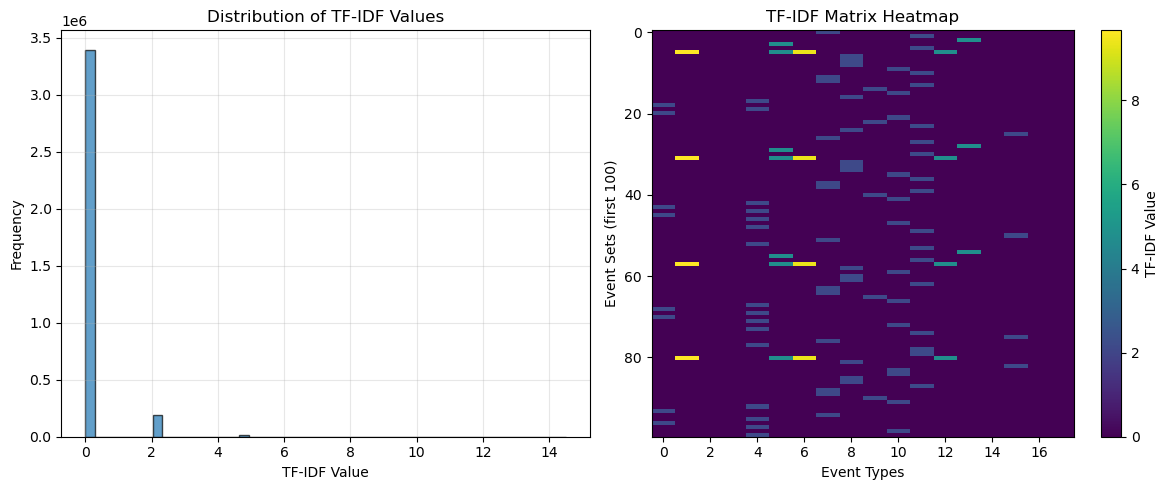

In [14]:
def compute_tfidf(event_sets_df):
    """
    Compute TF-IDF vectors for event sets
    
    Parameters:
    - event_sets_df: DataFrame with event sets
    
    Returns:
    - tfidf_matrix: numpy array of TF-IDF vectors
    - event_names: list of unique event names
    - labels: array of labels
    """
    # Get all unique event names
    all_events = set()
    for event_counts in event_sets_df['event_counts']:
        all_events.update(event_counts.keys())
    event_names = sorted(list(all_events))
    
    m = len(event_sets_df)  # Total number of event sets
    n = len(event_names)     # Total number of unique event types
    
    # Compute document frequency for each event type
    df_counts = defaultdict(int)  # n_j: number of event sets containing event j
    for event_counts in event_sets_df['event_counts']:
        for event_name in event_counts.keys():
            df_counts[event_name] += 1
    
    # Compute IDF for each event
    idf = {}
    for event_name in event_names:
        idf[event_name] = np.log(m / df_counts[event_name]) if df_counts[event_name] > 0 else 0
    
    # Compute TF-IDF vectors
    tfidf_matrix = np.zeros((m, n))
    
    for i, event_counts in enumerate(event_sets_df['event_counts']):
        for j, event_name in enumerate(event_names):
            tf = event_counts.get(event_name, 0)  # Term frequency
            tfidf_matrix[i, j] = tf * idf[event_name]
    
    labels = event_sets_df['label'].values
    
    return tfidf_matrix, event_names, labels

# Compute TF-IDF
print("Computing TF-IDF vectors...")
tfidf_matrix, event_names, labels = compute_tfidf(event_sets)

print(f"\nTF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of unique event types: {len(event_names)}")
print(f"Event types: {event_names}")

# Visualize TF-IDF distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(tfidf_matrix.flatten(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('TF-IDF Value')
plt.ylabel('Frequency')
plt.title('Distribution of TF-IDF Values')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.imshow(tfidf_matrix[:100], aspect='auto', cmap='viridis')
plt.xlabel('Event Types')
plt.ylabel('Event Sets (first 100)')
plt.title('TF-IDF Matrix Heatmap')
plt.colorbar(label='TF-IDF Value')

plt.tight_layout()
plt.show()

## 4. Event Profile Generation Using Basepoints

The paper's novel contribution: Instead of using all TF-IDF features, they:
1. Select k basepoints (rare event patterns)
2. Calculate cosine similarity between each event set and basepoints
3. Use similarity scores as features (dimensionality reduction)

This reduces features from n (number of event types) to k (number of basepoints).

Selecting basepoints...

Selected 3 basepoints
Basepoint indices: [173486   8735   8719]

Computing event profiles...

Event profiles shape: (200020, 3)
Dimensionality reduction: 18 → 3


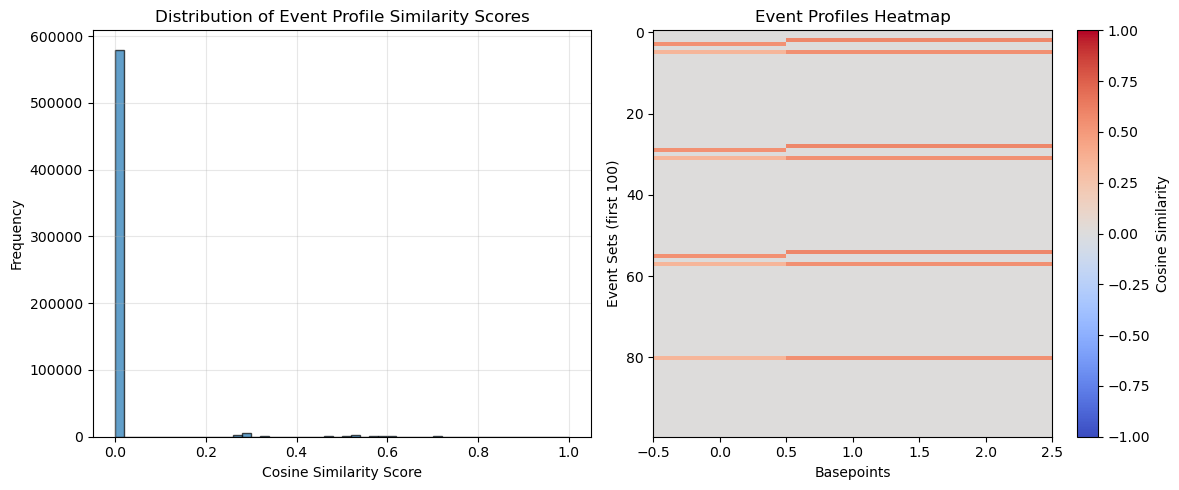

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

def select_basepoints(tfidf_matrix, k=None, percentile=0.2):
    """
    Select k basepoints from TF-IDF matrix
    Basepoints are rare event patterns (low frequency)
    
    Parameters:
    - tfidf_matrix: TF-IDF matrix (m x n)
    - k: Number of basepoints (if None, uses percentile of n)
    - percentile: Percentage of n to use as k (default 0.2 = 20%)
    
    Returns:
    - basepoints: indices of selected basepoints
    - basepoint_vectors: TF-IDF vectors of basepoints
    """
    m, n = tfidf_matrix.shape
    
    if k is None:
        k = max(int(n * percentile), 5)  # At least 5 basepoints
    
    # Calculate rarity score: sum of inverse frequencies
    # Rare events have high TF-IDF in few documents
    rarity_scores = np.zeros(m)
    for i in range(m):
        # Focus on non-zero elements (events that occurred)
        non_zero_mask = tfidf_matrix[i] > 0
        if non_zero_mask.any():
            # Higher score for events with high TF-IDF (rare events)
            rarity_scores[i] = np.sum(tfidf_matrix[i][non_zero_mask])
    
    # Select top k rare event sets as basepoints
    basepoint_indices = np.argsort(rarity_scores)[-k:]
    
    # Remove redundant basepoints (too similar to each other)
    basepoint_vectors = tfidf_matrix[basepoint_indices]
    similarity_matrix = cosine_similarity(basepoint_vectors)
    
    # Keep basepoints with low similarity to others
    final_basepoints = [basepoint_indices[0]]
    for i in range(1, len(basepoint_indices)):
        # Check similarity with already selected basepoints
        similarities = [similarity_matrix[i][final_basepoints.index(bp)] 
                       for bp in final_basepoints if bp in basepoint_indices]
        if not similarities or max(similarities) < 0.8:  # Threshold for redundancy
            final_basepoints.append(basepoint_indices[i])
        if len(final_basepoints) >= k:
            break
    
    final_basepoints = np.array(final_basepoints)
    basepoint_vectors = tfidf_matrix[final_basepoints]
    
    return final_basepoints, basepoint_vectors

def compute_event_profiles(tfidf_matrix, basepoint_vectors):
    """
    Compute event profiles by calculating cosine similarity
    between each event set and basepoints
    
    Parameters:
    - tfidf_matrix: TF-IDF matrix (m x n)
    - basepoint_vectors: Basepoint TF-IDF vectors (k x n)
    
    Returns:
    - event_profiles: Similarity matrix (m x k)
    """
    # Compute cosine similarity between all event sets and basepoints
    event_profiles = cosine_similarity(tfidf_matrix, basepoint_vectors)
    
    return event_profiles

# Select basepoints and compute event profiles
print("Selecting basepoints...")
basepoint_indices, basepoint_vectors = select_basepoints(tfidf_matrix, percentile=0.25)

print(f"\nSelected {len(basepoint_indices)} basepoints")
print(f"Basepoint indices: {basepoint_indices}")

print("\nComputing event profiles...")
event_profiles = compute_event_profiles(tfidf_matrix, basepoint_vectors)

print(f"\nEvent profiles shape: {event_profiles.shape}")
print(f"Dimensionality reduction: {tfidf_matrix.shape[1]} → {event_profiles.shape[1]}")

# Visualize event profiles
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(event_profiles.flatten(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Event Profile Similarity Scores')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.imshow(event_profiles[:100], aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
plt.xlabel('Basepoints')
plt.ylabel('Event Sets (first 100)')
plt.title('Event Profiles Heatmap')
plt.colorbar(label='Cosine Similarity')

plt.tight_layout()
plt.show()

## 5. Prepare Data for Deep Learning

Split data into training and testing sets, and prepare labels.

In [16]:
# Prepare features and labels
X = event_profiles
y = (labels == 'THREAT').astype(int)  # Binary classification: 0=Normal, 1=Threat

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"  - Normal: {(y_train == 0).sum()}")
print(f"  - Threat: {(y_train == 1).sum()}")

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  - Normal: {(y_test == 0).sum()}")
print(f"  - Threat: {(y_test == 1).sum()}")

print(f"\nFeature dimension: {X_train.shape[1]}")

Training set: 160016 samples
  - Normal: 151925
  - Threat: 8091

Test set: 40004 samples
  - Normal: 37981
  - Threat: 2023

Feature dimension: 3


## 6. Model 1: Fully Connected Neural Network (FCNN)

The paper uses an 11-layer FCNN:
- 1 input layer
- 9 hidden layers with sizes: [1650, 1850, 2048, 1792, 1536, 1280, 1024, 768, 512]
- 1 output layer with softmax
- Activation: Leaky ReLU

We'll create a simplified version adapted to our feature size.

In [17]:
def build_fcnn_model(input_dim, hidden_layers=None):
    """
    Build Fully Connected Neural Network (FCNN)
    
    Parameters:
    - input_dim: Input dimension
    - hidden_layers: List of hidden layer sizes
    """
    if hidden_layers is None:
        # Adapt hidden layers based on input dimension
        base = max(input_dim * 8, 256)
        hidden_layers = [
            base, 
            int(base * 1.2), 
            int(base * 1.4), 
            int(base * 1.2),
            base,
            int(base * 0.8),
            int(base * 0.6),
            int(base * 0.4),
            int(base * 0.2)
        ]
    
    model = models.Sequential(name='FCNN')
    
    # Input layer
    model.add(layers.Input(shape=(input_dim,)))
    
    # Hidden layers with Leaky ReLU
    for i, units in enumerate(hidden_layers):
        model.add(layers.Dense(units, name=f'dense_{i+1}'))
        model.add(layers.LeakyReLU(alpha=0.01, name=f'leaky_relu_{i+1}'))
        model.add(layers.Dropout(0.3, name=f'dropout_{i+1}'))
    
    # Output layer
    model.add(layers.Dense(2, activation='softmax', name='output'))
    
    return model

# Build FCNN model
print("Building FCNN model...")
fcnn_model = build_fcnn_model(X_train.shape[1])

# Compile model
fcnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("\nModel architecture:")
fcnn_model.summary()

Building FCNN model...

Model architecture:


Model: "FCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_1 (LeakyReLU)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 307)            │        78,899 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_2 (LeakyReLU)        │ (None, 307)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 307)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 358)            │       110,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_3 (LeakyReLU)        │ (None, 358)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 358)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 307)            │       110,213 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_4 (LeakyReLU)        │ (None, 307)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 307)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_5 (LeakyReLU)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 204)            │        52,428 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_6 (LeakyReLU)        │ (None, 204)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 204)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 153)            │        31,365 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_7 (LeakyReLU)        │ (None, 153)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 153)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 102)            │        15,708 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_8 (LeakyReLU)        │ (None, 102)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 102)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 51)             │         5,25

 Total params: 484,106 (1.85 MB)

 Trainable params: 484,106 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train FCNN
print("Training FCNN model...\n")

fcnn_history = fcnn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)

# Evaluate FCNN
print("\nEvaluating FCNN on test set...")
fcnn_results = fcnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {fcnn_results[0]:.4f}")
print(f"Test Accuracy: {fcnn_results[1]:.4f}")
print(f"Test Precision: {fcnn_results[2]:.4f}")
print(f"Test Recall: {fcnn_results[3]:.4f}")

Training FCNN model...

Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd_4 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\ProgramData\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\ProgramData\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "c:\ProgramData\anaconda3\Lib\asyncio\base_events.py", line 683, in run_forever

  File "c:\ProgramData\anaconda3\Lib\asyncio\base_events.py", line 2042, in _run_once

  File "c:\ProgramData\anaconda3\Lib\asyncio\events.py", line 89, in _run

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\ProgramData\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\murhc\AppData\Local\Temp\ipykernel_33008\2224215179.py", line 4, in <module>

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 399, in fit

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 241, in function

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 154, in multi_step_on_iterator

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 125, in wrapper

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 134, in one_step_on_data

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 88, in train_step

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\trainer.py", line 490, in compute_metrics

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 343, in update_state

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\compile_utils.py", line 21, in update_state

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\metrics\confusion_metrics.py", line 522, in update_state

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 595, in update_confusion_matrix_variables

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 568, in weighted_assign_add

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\ops\numpy.py", line 4407, in logical_and

  File "c:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 1983, in logical_and

Incompatible shapes: [1,64] vs. [1,32]
	 [[{{node LogicalAnd_4}}]] [Op:__inference_multi_step_on_iterator_9494]

## 7. Model 2: Convolutional Neural Network (CNN)

The paper uses CNN to learn spatial features from event profiles.
Event profiles are reshaped into 2D arrays for CNN input.

In [ ]:
def reshape_for_cnn(X, target_size=None):
    """
    Reshape 1D event profiles to 2D for CNN
    Pad with zeros if necessary to create square-ish shape
    """
    n_samples, n_features = X.shape
    
    if target_size is None:
        # Find closest square dimensions
        side = int(np.ceil(np.sqrt(n_features)))
        target_size = side * side
    
    # Pad with zeros if needed
    if n_features < target_size:
        padding = np.zeros((n_samples, target_size - n_features))
        X_padded = np.concatenate([X, padding], axis=1)
    else:
        X_padded = X[:, :target_size]
    
    # Reshape to 2D
    side = int(np.sqrt(target_size))
    X_2d = X_padded.reshape(n_samples, side, side, 1)
    
    return X_2d, (side, side)

# Reshape data for CNN
X_train_cnn, cnn_shape = reshape_for_cnn(X_train)
X_test_cnn, _ = reshape_for_cnn(X_test, target_size=cnn_shape[0] * cnn_shape[1])

print(f"Reshaped for CNN: {X_train_cnn.shape}")
print(f"2D shape: {cnn_shape}")

In [ ]:
def build_cnn_model(input_shape):
    """
    Build Convolutional Neural Network (CNN)
    
    Parameters:
    - input_shape: Shape of input (height, width, channels)
    """
    model = models.Sequential(name='CNN')
    
    # Input layer
    model.add(layers.Input(shape=input_shape))
    
    # Convolutional layers with max pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.25, name='dropout1'))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.25, name='dropout2'))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'))
    model.add(layers.MaxPooling2D((2, 2), name='pool3'))
    model.add(layers.Dropout(0.25, name='dropout3'))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4'))
    
    # Flatten and fully connected layers
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(512, activation='relu', name='dense1'))
    model.add(layers.Dropout(0.5, name='dropout4'))
    model.add(layers.Dense(256, activation='relu', name='dense2'))
    model.add(layers.Dropout(0.5, name='dropout5'))
    
    # Output layer
    model.add(layers.Dense(2, activation='softmax', name='output'))
    
    return model

# Build CNN model
print("Building CNN model...")
cnn_model = build_cnn_model(X_train_cnn.shape[1:])

# Compile model
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("\nModel architecture:")
cnn_model.summary()

In [ ]:
# Train CNN
print("Training CNN model...\n")

cnn_history = cnn_model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)

# Evaluate CNN
print("\nEvaluating CNN on test set...")
cnn_results = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss: {cnn_results[0]:.4f}")
print(f"Test Accuracy: {cnn_results[1]:.4f}")
print(f"Test Precision: {cnn_results[2]:.4f}")
print(f"Test Recall: {cnn_results[3]:.4f}")

## 8. Model 3: Long Short-Term Memory (LSTM)

LSTM learns temporal patterns in event profiles.
Event profiles are treated as sequences.

In [ ]:
def reshape_for_lstm(X, timesteps=None):
    """
    Reshape event profiles for LSTM
    Each feature becomes a timestep
    """
    n_samples, n_features = X.shape
    
    if timesteps is None:
        timesteps = n_features
    
    # Reshape to (samples, timesteps, features)
    # Each feature is treated as one timestep with 1 feature
    X_lstm = X.reshape(n_samples, timesteps, 1)
    
    return X_lstm

# Reshape data for LSTM
X_train_lstm = reshape_for_lstm(X_train)
X_test_lstm = reshape_for_lstm(X_test)

print(f"Reshaped for LSTM: {X_train_lstm.shape}")

In [ ]:
def build_lstm_model(input_shape, lstm_units=None):
    """
    Build Long Short-Term Memory (LSTM) network
    
    Parameters:
    - input_shape: Shape of input (timesteps, features)
    - lstm_units: List of LSTM layer sizes
    """
    if lstm_units is None:
        lstm_units = [256, 128, 64]  # Multi-layer LSTM
    
    model = models.Sequential(name='LSTM')
    
    # Input layer
    model.add(layers.Input(shape=input_shape))
    
    # LSTM layers
    for i, units in enumerate(lstm_units[:-1]):
        model.add(layers.LSTM(
            units, 
            return_sequences=True, 
            name=f'lstm_{i+1}'
        ))
        model.add(layers.Dropout(0.3, name=f'dropout_lstm_{i+1}'))
    
    # Last LSTM layer (no return_sequences)
    model.add(layers.LSTM(lstm_units[-1], name=f'lstm_{len(lstm_units)}'))
    model.add(layers.Dropout(0.3, name=f'dropout_lstm_{len(lstm_units)}'))
    
    # Fully connected layers
    model.add(layers.Dense(128, activation='relu', name='dense1'))
    model.add(layers.Dropout(0.5, name='dropout_dense1'))
    model.add(layers.Dense(64, activation='relu', name='dense2'))
    model.add(layers.Dropout(0.5, name='dropout_dense2'))
    
    # Output layer
    model.add(layers.Dense(2, activation='softmax', name='output'))
    
    return model

# Build LSTM model
print("Building LSTM model...")
lstm_model = build_lstm_model(X_train_lstm.shape[1:])

# Compile model
lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

print("\nModel architecture:")
lstm_model.summary()

In [ ]:
# Train LSTM
print("Training LSTM model...\n")

lstm_history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)

# Evaluate LSTM
print("\nEvaluating LSTM on test set...")
lstm_results = lstm_model.evaluate(X_test_lstm, y_test, verbose=0)
print(f"Test Loss: {lstm_results[0]:.4f}")
print(f"Test Accuracy: {lstm_results[1]:.4f}")
print(f"Test Precision: {lstm_results[2]:.4f}")
print(f"Test Recall: {lstm_results[3]:.4f}")

## 9. Comprehensive Evaluation and Comparison

Compare all three models using the metrics from the paper:
- Accuracy
- TPR (True Positive Rate / Recall)
- FPR (False Positive Rate)
- F-measure (F1 Score)
- ROC Curve and AUC

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """
    Comprehensive evaluation of a model
    """
    # Predictions
    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)  # TPR
    f1 = f1_score(y_test, y_pred)
    
    # Confusion matrix for FPR
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    # ROC curve
    fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr_roc, tpr_roc)
    
    results = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'tpr': recall,
        'fpr': fpr,
        'f1_score': f1,
        'auc': roc_auc,
        'confusion_matrix': cm,
        'fpr_roc': fpr_roc,
        'tpr_roc': tpr_roc
    }
    
    return results

# Evaluate all models
print("Evaluating all models...\n")

fcnn_eval = evaluate_model(fcnn_model, X_test, y_test, 'FCNN')
cnn_eval = evaluate_model(cnn_model, X_test_cnn, y_test, 'CNN')
lstm_eval = evaluate_model(lstm_model, X_test_lstm, y_test, 'LSTM')

# Create comparison table
comparison_df = pd.DataFrame([
    {
        'Model': eval_result['model'],
        'Accuracy': f"{eval_result['accuracy']:.4f}",
        'Precision': f"{eval_result['precision']:.4f}",
        'TPR (Recall)': f"{eval_result['tpr']:.4f}",
        'FPR': f"{eval_result['fpr']:.4f}",
        'F1-Score': f"{eval_result['f1_score']:.4f}",
        'AUC': f"{eval_result['auc']:.4f}"
    }
    for eval_result in [fcnn_eval, cnn_eval, lstm_eval]
])

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

In [ ]:
# Visualization: Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, eval_result in enumerate([fcnn_eval, cnn_eval, lstm_eval]):
    cm = eval_result['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Normal', 'Threat'],
                yticklabels=['Normal', 'Threat'])
    axes[idx].set_title(f"{eval_result['model']} Confusion Matrix")
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [ ]:
# Visualization: ROC Curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green']
for idx, eval_result in enumerate([fcnn_eval, cnn_eval, lstm_eval]):
    plt.plot(
        eval_result['fpr_roc'], 
        eval_result['tpr_roc'],
        color=colors[idx],
        lw=2,
        label=f"{eval_result['model']} (AUC = {eval_result['auc']:.4f})"
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Visualization: Training History
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = [
    (fcnn_history, 'FCNN'),
    (cnn_history, 'CNN'),
    (lstm_history, 'LSTM')
]

for idx, (history, name) in enumerate(histories):
    # Accuracy plot
    axes[0, idx].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0, idx].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0, idx].set_title(f'{name} - Accuracy')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Accuracy')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)
    
    # Loss plot
    axes[1, idx].plot(history.history['loss'], label='Train Loss')
    axes[1, idx].plot(history.history['val_loss'], label='Val Loss')
    axes[1, idx].set_title(f'{name} - Loss')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Loss')
    axes[1, idx].legend()
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Comparison with Traditional Machine Learning

The paper compares deep learning models with traditional ML methods:
- Support Vector Machine (SVM)
- k-Nearest Neighbors (k-NN)
- Random Forest (RF)
- Naive Bayes (NB)
- Decision Tree (DT)

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Train traditional ML models
print("Training traditional machine learning models...\n")

ml_models = {
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

ml_results = []

for name, model in ml_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    if y_pred_proba is not None:
        fpr_roc, tpr_roc, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr_roc, tpr_roc)
    else:
        roc_auc = None
    
    ml_results.append({
        'Model': name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision': f"{precision:.4f}",
        'TPR (Recall)': f"{recall:.4f}",
        'FPR': f"{fpr:.4f}",
        'F1-Score': f"{f1:.4f}",
        'AUC': f"{roc_auc:.4f}" if roc_auc else 'N/A'
    })

ml_comparison_df = pd.DataFrame(ml_results)

print("\n" + "="*80)
print("TRADITIONAL ML MODELS COMPARISON")
print("="*80)
print(ml_comparison_df.to_string(index=False))
print("="*80)

In [ ]:
# Combined comparison: Deep Learning vs Traditional ML
all_results = pd.concat([comparison_df, ml_comparison_df], ignore_index=True)

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("Deep Learning (FCNN, CNN, LSTM) vs Traditional ML (SVM, k-NN, RF, NB, DT)")
print("="*80)
print(all_results.to_string(index=False))
print("="*80)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Convert string percentages back to float for plotting
metrics_to_plot = ['Accuracy', 'F1-Score']
plot_data = all_results.copy()
for col in metrics_to_plot:
    plot_data[col] = plot_data[col].astype(float)

x = np.arange(len(plot_data))
width = 0.35

axes[0].bar(x - width/2, plot_data['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x + width/2, plot_data['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(plot_data['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0, 1.1])

# TPR vs FPR scatter
plot_data['TPR'] = plot_data['TPR (Recall)'].astype(float)
plot_data['FPR_val'] = plot_data['FPR'].astype(float)

dl_mask = plot_data['Model'].isin(['FCNN', 'CNN', 'LSTM'])
axes[1].scatter(plot_data[dl_mask]['FPR_val'], plot_data[dl_mask]['TPR'], 
                s=200, alpha=0.7, label='Deep Learning', marker='o')
axes[1].scatter(plot_data[~dl_mask]['FPR_val'], plot_data[~dl_mask]['TPR'], 
                s=200, alpha=0.7, label='Traditional ML', marker='s')

for idx, row in plot_data.iterrows():
    axes[1].annotate(row['Model'], (row['FPR_val'], row['TPR']), 
                     fontsize=9, ha='right')

axes[1].set_xlabel('False Positive Rate (FPR)')
axes[1].set_ylabel('True Positive Rate (TPR)')
axes[1].set_title('TPR vs FPR: Deep Learning vs Traditional ML')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Key Insights and Conclusions

### Summary of the Paper's Methodology:

1. **Event Profiling**: Converting raw IPS events into meaningful profiles using:
   - Sliding window aggregation
   - TF-IDF normalization
   - Basepoint similarity for dimensionality reduction

2. **Deep Learning Models**: Three architectures tested:
   - **FCNN**: Fully connected layers for general pattern recognition
   - **CNN**: Convolutional layers for spatial feature extraction
   - **LSTM**: Recurrent layers for temporal pattern learning

3. **Performance**: Deep learning models outperformed traditional ML methods in:
   - Accuracy
   - True Positive Rate (threat detection)
   - False Positive Rate (fewer false alarms)
   - F1-Score (balanced performance)

### Advantages of the Approach:

- **Scalability**: Event profiling handles very large-scale data
- **Dimensionality Reduction**: Basepoint method reduces features while preserving information
- **Automation**: Reduces manual effort for security analysts
- **Real-world Applicability**: Tested on actual IPS data from SOC

### Practical Applications:

- Security Operations Centers (SOC)
- Automated threat detection systems
- Real-time IPS/IDS alert classification
- Reducing alert fatigue for security analysts

## 12. Save Models and Results

In [ ]:
# Save models
print("Saving trained models...")
fcnn_model.save('fcnn_model.h5')
cnn_model.save('cnn_model.h5')
lstm_model.save('lstm_model.h5')
print("Models saved successfully!")

# Save comparison results
all_results.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to 'model_comparison_results.csv'")

# Save processed data
np.save('event_profiles.npy', event_profiles)
np.save('labels.npy', labels)
np.save('basepoint_vectors.npy', basepoint_vectors)
print("Processed data saved successfully!")

## Next Steps for Your Project

To extend this implementation:

1. **Use Real Datasets**: Download NSLKDD or CICIDS2017 for actual testing
2. **Hyperparameter Tuning**: Optimize model architectures and training parameters
3. **Feature Engineering**: Add more sophisticated features from event data
4. **Online Learning**: Implement incremental learning for concept drift
5. **Explainability**: Add SHAP or LIME for model interpretability
6. **Deployment**: Create a real-time prediction API
7. **Dashboard**: Build a web interface for SOC analysts

### Recommended Resources:

- NSLKDD Dataset: https://www.unb.ca/cic/datasets/nsl.html
- CICIDS2017 Dataset: https://www.unb.ca/cic/datasets/ids-2017.html
- TensorFlow Documentation: https://www.tensorflow.org/
- Scikit-learn Documentation: https://scikit-learn.org/

# ACKNOWLEDJEMENTS


The implementation is improvement from the article: 
- Cyber Threat Detection Based on Artificial
Neural Networks Using Event Profiles (https://scispace.com/pdf/cyber-threat-detection-based-on-artificial-neural-networks-3i8csdva7s.pdf)

